# Beiwe-visualizer

In [1]:
# disable autosave so that multiple user browser can attach the same notebook
%autosave 0

# enable notebook mode so that we can drag, resize and save plots
%matplotlib notebook

from core import *

Autosave disabled


<IPython.core.display.Javascript object>

In [2]:
HBox([dropdown_studies, fileupload])

# Data Dashboard

In [3]:
VBox([HBox(W.children[0:5]), HBox(W.children[5:10]), HBox(W.children[10:15]), HBox(W.children[15:-1]), W.children[-1]])

# Clinical Dashboard

In [4]:
def drawAll(Username, CyclePeriod, DoPlot):
    global dbg_df, g_plot
    if not DoPlot:
        clear_output()
        return
    
    # init parameters
    file_suffix = '.csv.gz'
    
    # sociability messages
    df = load_df(Username, 'sociabilityLog'+file_suffix).copy()
    df.orientation = df.orientation.apply(lambda t: ('outgoing' if t==0 else 'incoming'))
    plot1a = draw(df, None, None, 0.0, False, 'sociabilityLog'+file_suffix, 'grouped values by each interval', '1D', 0.0, CyclePeriod, 'time chart stacked bar', 'orientation', 10,
                  '<entry-count>', True, 'no sort', True, False, False, None, size_ratio=1, set_title='WhatsApp Messages', set_ylabel='log(#)')
    plot1b = draw(Username, None, None, 0.0, False, 'textsLog'+file_suffix, 'grouped values by each interval', '1D', 0.0, CyclePeriod, 'time chart stacked bar', 'sent vs received', 10,
                  '<entry-count>', True, 'no sort', True, False, False, None, size_ratio=1, set_title='SMS Messages', set_ylabel='log(#)')
    
    # sociability calls
    df = load_df(Username, 'sociabilityCallLog'+file_suffix)[['recordedDuration']]
    df = df.append(load_df(Username, 'callLog'+file_suffix)[['duration in seconds']].rename(columns={'duration in seconds':'recordedDuration'}))
    plot2 = draw(df.sort_index()/60, None, None, 0.0, False, 'sociabilityCallLog'+file_suffix, 'sum in each interval', '1D', 0.0, CyclePeriod, 'time chart (bar)', 'recordedDuration', 10,
                 '<entry-count>', False, 'no sort', False, False, False, None, size_ratio=1, set_title='WhatsApp/Phone Call Duration', set_ylabel='minutes')
    
    # sleep stage
    dbg_df = df = load_df(Username, 'sleep'+file_suffix).copy()
    df = df[df.Level!='main']
    df.Seconds /= 3600
    plot3 = draw(df, None, None, 0.0, False, 'sleep'+file_suffix, 'grouped values by each interval', '1D', 0.5, CyclePeriod, 'time chart stacked bar', 'Level', 10,
                 'Seconds', True, 'no sort', False, False, False, None, size_ratio=1, set_title='Sleep Stage', set_ylabel='hours')
    
    # sleep efficiency
    plot4 = draw(Username, None, None, 0.0, False, 'sleep'+file_suffix, 'mean value in each interval', '1D', 0.5, CyclePeriod, 'time chart (bar)', 'Efficiency', 10,
                 '<entry-count>', True, 'no sort', False, False, False, None, size_ratio=1, set_title='Sleep Efficiency', set_ylabel='%')
    
    # mobility: Radius of Gyration
    plot5 = draw(Username, None, None, 0.0, False, 'gps-mobility'+file_suffix, 'mean value in each interval', '1D', 0.0, CyclePeriod, 'time chart (bar)', 'RoG', 'mean',
                 '<entry-count>', True, 'no sort', False, False, False, None, size_ratio=1, set_title='Mobility: Radius of Gyration', set_yscale='log', set_ylabel='m')
    
    # mobility: home time
    plot6 = draw(Username, None, None, 0.0, False, 'gps-mobility'+file_suffix, 'mean value in each interval', '1D', 0.0, CyclePeriod, 'time chart (bar)', 'Hometime', 'mean',
                 '<entry-count>', True, 'no sort', False, False, False, None, size_ratio=1, set_title='Mobility: Home Time', set_ylabel='minutes')
    
    # mobility: steps
    plot7 = draw(Username, None, None, 0.0, False, 'steps'+file_suffix, 'sum in each interval', '1D', 0.0, CyclePeriod, 'time chart (bar)', 'StepsCount', 'mean',
                 '<entry-count>', True, 'no sort', False, False, False, None, size_ratio=1, set_title='Mobility: Steps')
    
    # taps in Apps
    plot8 = draw(Username, None, None, 0.0, False, 'tapsLog'+file_suffix, 'grouped values by each interval', '1D', 0.0, CyclePeriod, 'time chart stacked bar', 'in_app_name', 10,
                 '<entry-count>', True, 'no sort', True, False, False, None, size_ratio=1, set_title='Taps in Apps', set_ylabel='log(#)')

    # heart rate
    plot9 = draw(Username, None, None, 0.0, False, 'heart'+file_suffix, 'grouped values by each interval', '1D', 0.0, CyclePeriod, 'time chart grouped box plot', 'HR', 'mean',
                 '<entry-count>', False, 'no sort', False, False, False, None, size_ratio=1, set_title='Heart Rate', set_ylabel='BPM')
    
    # ambient light heatmap
    plot10 = draw(Username, None, None, 0.0, False, 'light'+file_suffix, 'pass through all', '1D', 0.0, CyclePeriod, 'value heatmap', 'value', 'mean',
                 '<entry-count>', True, 'no sort', True, False, False, None, size_ratio=1, set_title='Ambient Light Heatmap')
    
cycle_period1 = IntSlider(min=0, max=100, step=1, value=21, continuous_update=False, description='Cycle (days)')
W = interactive(drawAll, Username = dropdown_userlist, CyclePeriod = cycle_period1, DoPlot = ToggleButton(value=False, description='Update Plot'))
VBox([HBox(W.children[0:-1]), W.children[-1]])

## Padding (Jupyter notebook UI has a bug that if the following is removed, the UI will scroll upon every interactive click)

<IPython.core.display.Javascript object>


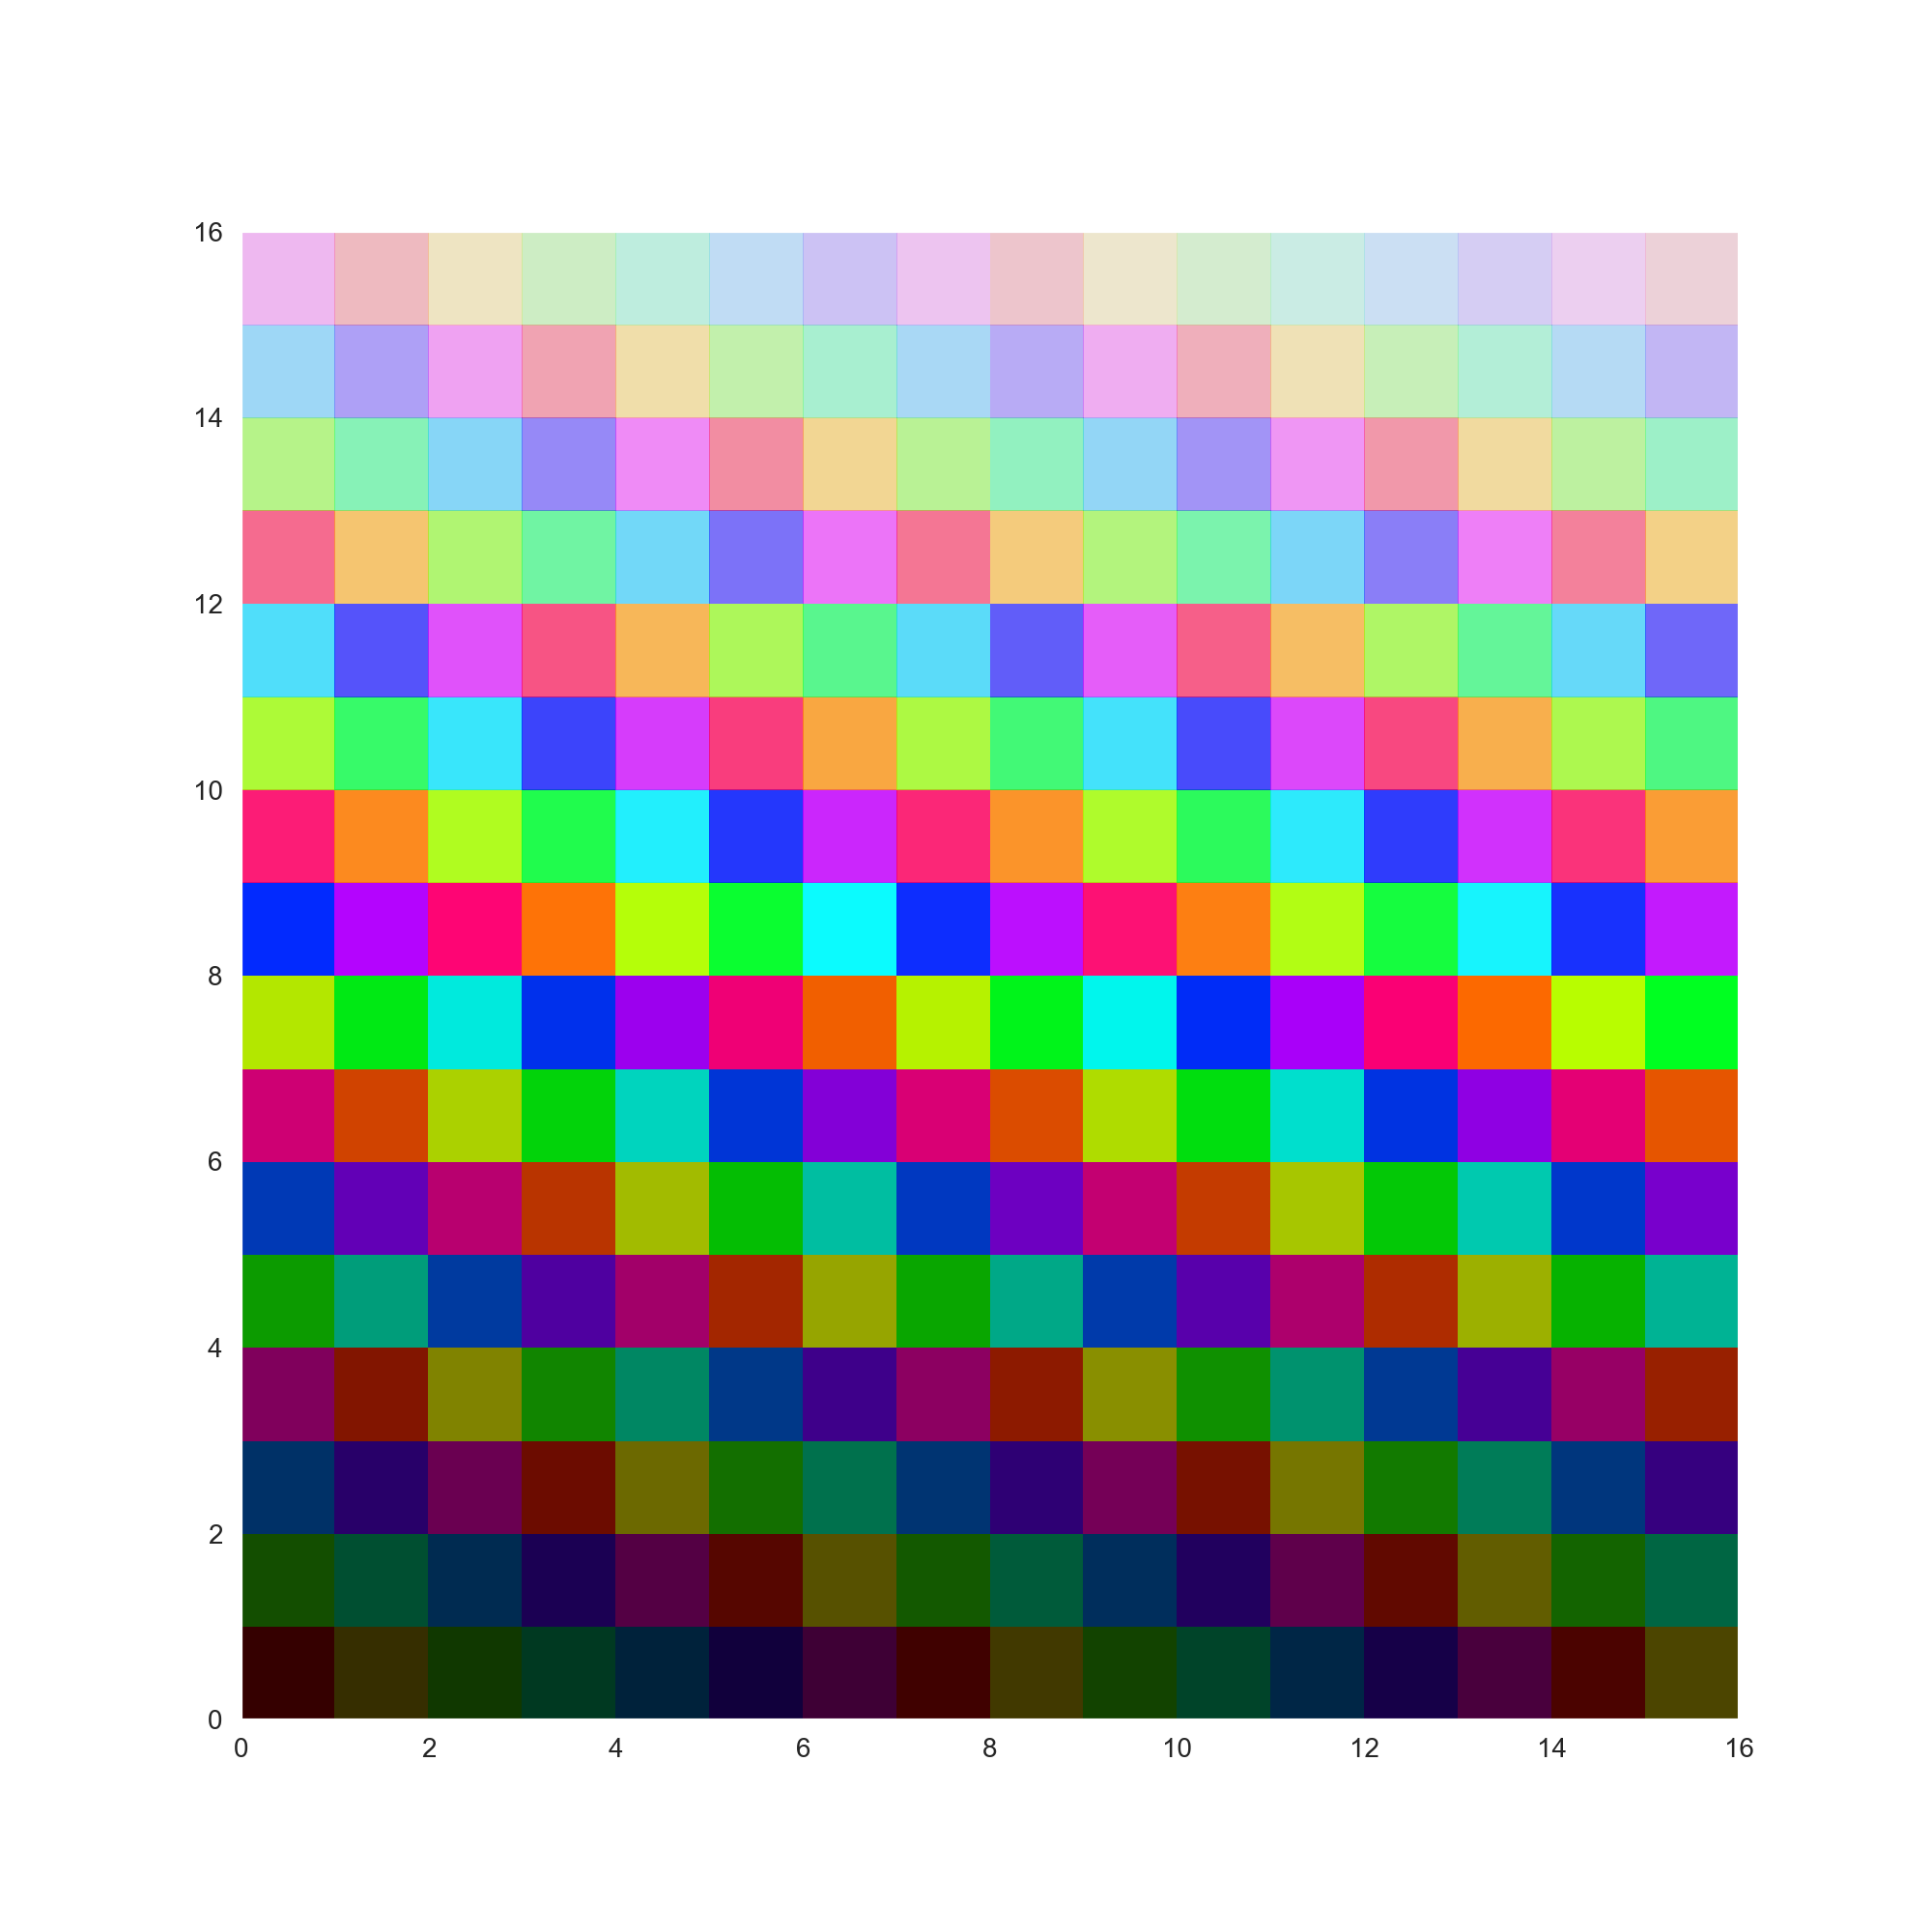

In [5]:
from matplotlib.colors import ListedColormap

plt.switch_backend('nbAgg')

N = 16
H = np.arange(N*N).reshape([N,N])
fig = plt.figure(figsize=(10, 10))
ax = plt.pcolor(H, cmap=ListedColormap(generate_colormap(N*N)))